In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

# Preprocessing a Whole Slide Image

In this section, we will walk you through a general workflow on how to process WSI using LazySlide.

## import

The convention namespace for lazyslide is always `zs`.

In [3]:
import lazyslide as zs

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


## Open a WSI

Here we will download a lung carcinoma slide as example.

In [4]:
import pooch

slide = pooch.retrieve(
    "https://brd.nci.nih.gov/brd/imagedownload/GTEX-1117F-0526",
    fname="GTEX-1117F-0526.svs",
    path=".",
    known_hash="sha256:222ab7f2bb42dcd0bcfaccd910cb13be452b453499e6117ab553aa6cd60a135e",
)

## `wsidata`

In LazySlide, we mainly work with `WSIData`, which extends upon `SpatialData` with a WSI reader.

You can use `WSIData` directly as `SpatialData` in other scverse packages.

When you open an WSI, you will get a `WSIData`. The `WSIData` is usually stored side by side with your WSI file. If you want to attach antoher `WSIData`, you can specify one.

If you want to know more, please refer to [WSIData](https://wsidata.readthedocs.io/en/latest/intro/index.html).

In [5]:
from wsidata import open_wsi

wsi = open_wsi("GTEX-1117F-0526.svs")

## What's in the wsidata?

WSI: GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)
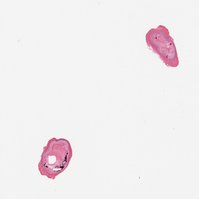

In [6]:
wsi

Let's check the slide metadata, this is a slide scan at 20X (magnification) with a mpp (micro per pixel) of 0.4942, it's shape is 19958×19919

In [7]:
wsi.properties

SlideProperties(shape=[19958, 19919], n_level=3, level_shape=[[19958, 19919], [4989, 4979], [2494, 2489]], level_downsample=[1.0, 4.000501706284455, 8.002609074152414], mpp=0.4942, magnification=20.0, bounds=[0, 0, 19919, 19958])

We can first take a quick look at slide, what does it look like.

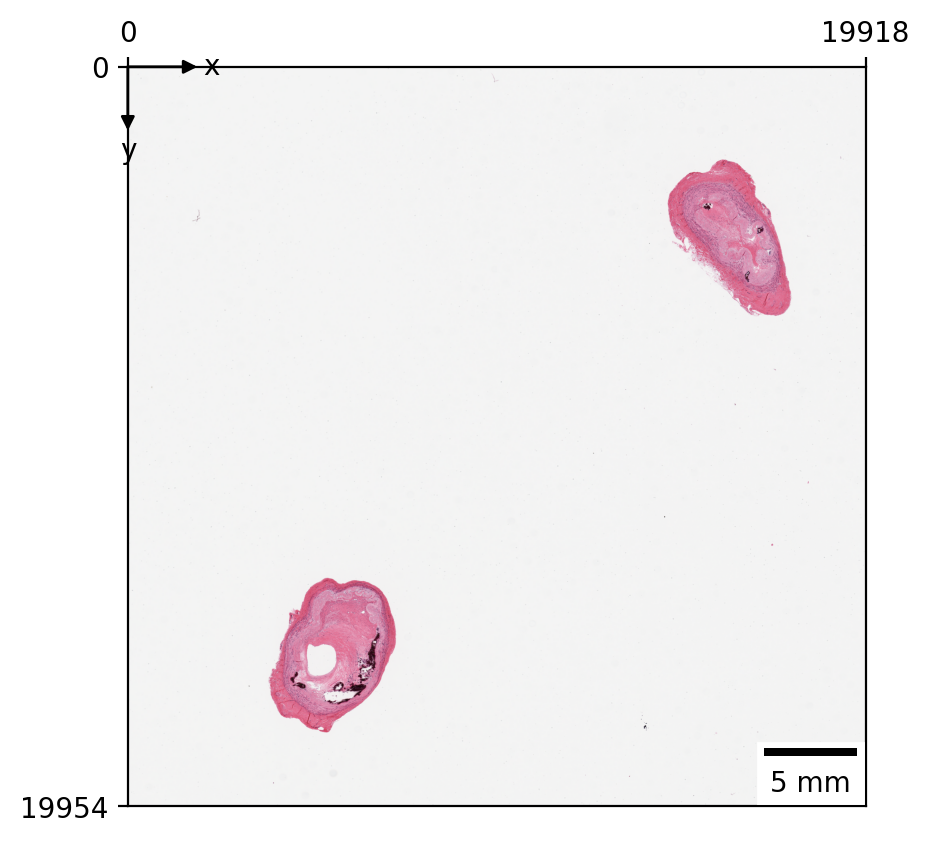

In [7]:
zs.pl.tissue(wsi)

## Tissue Segmentation

Before we proceed to other analysis, we need to segment the tissue from the slide.

In [17]:
zs.pp.find_tissues(wsi)

We can take a quick look of the segmentation result, the <span style="color: #117554;">greens</span> are the tissue borders, the <span style="color: #4379F2;">blues</span> are the holes that will be excluded.

The default parameters ususally works pretty well, but you may go ahead to adjust some parameters to fit your need.

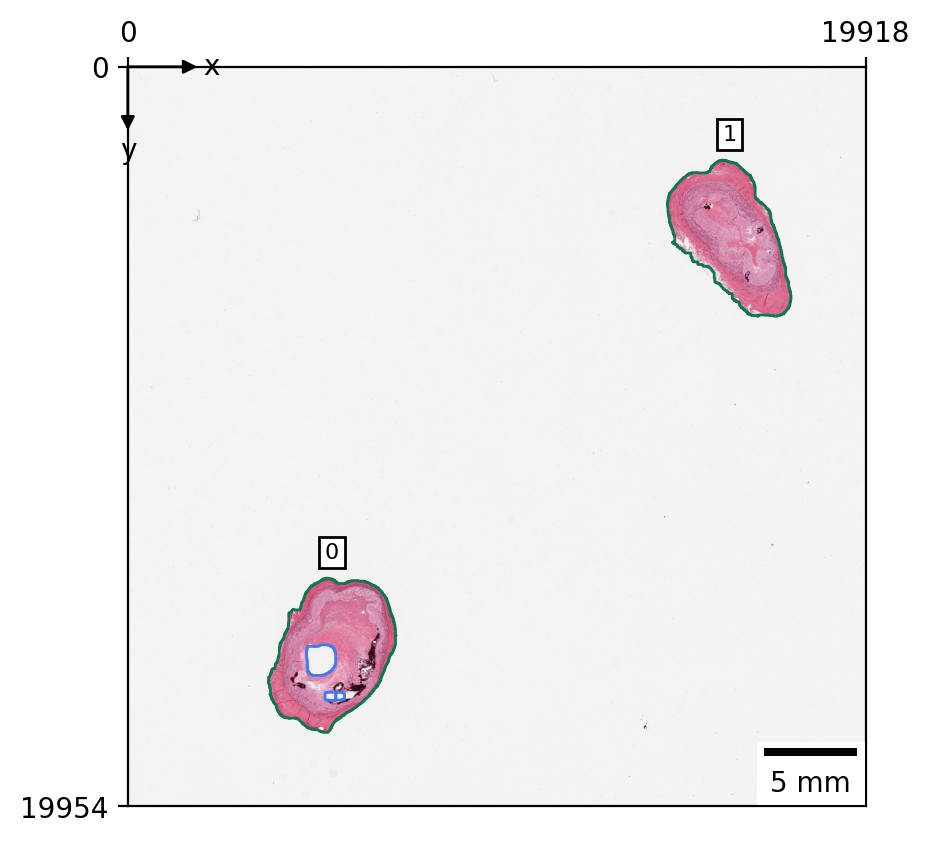

In [9]:
zs.pl.tissue(wsi)

If we print the wsidata again, you may notice a new `GeoDataFrame` named `tissues` is added to `Shapes`. 

WSI: GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
└── Shapes
      └── 'tissues': GeoDataFrame shape: (2, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tissues (Shapes)
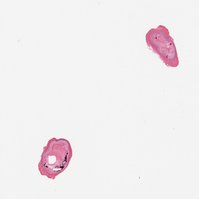

In [10]:
wsi

We can access the table with the key. A tissue table will always contains a `tissue_id` column so you can identify the exact tissue piece.

The `tissue_id` was also displayed when we plotted the tissue.

In [11]:
wsi["tissues"]

tissue_id                                           geometry
0          0  POLYGON ((5345.743 13804.501, 5337.74 13812.50...
1          1  POLYGON ((16029.226 2520.822, 16021.223 2528.8...

It's also possible to take a detail look on a specific tissue piece by specifying the `tissue_id`.

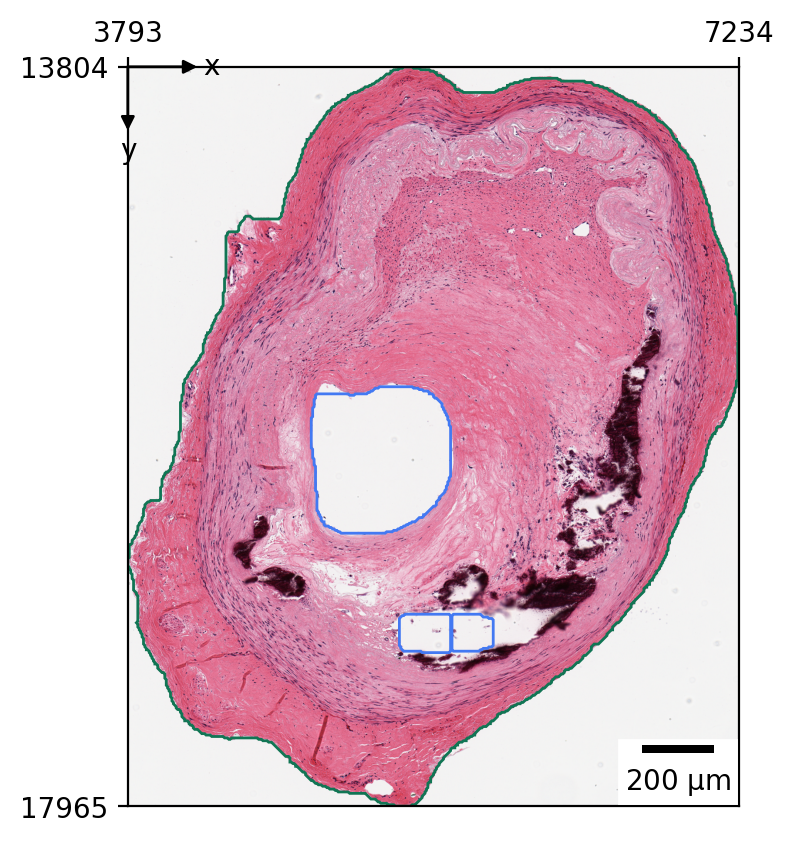

In [12]:
zs.pl.tissue(wsi, tissue_id=0)

### Deep leaerning based tissue segmentation

Besides traditional 

In [13]:
zs.seg.tissue(wsi, key_added="dl-tissues")

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `dl-tissues` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


WSI: GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
└── Shapes
      └── 'dl-tissues': GeoDataFrame shape: (3, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), dl-tissues (Shapes)
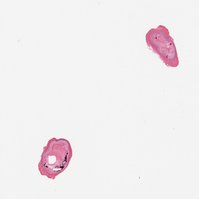

In [14]:
wsi

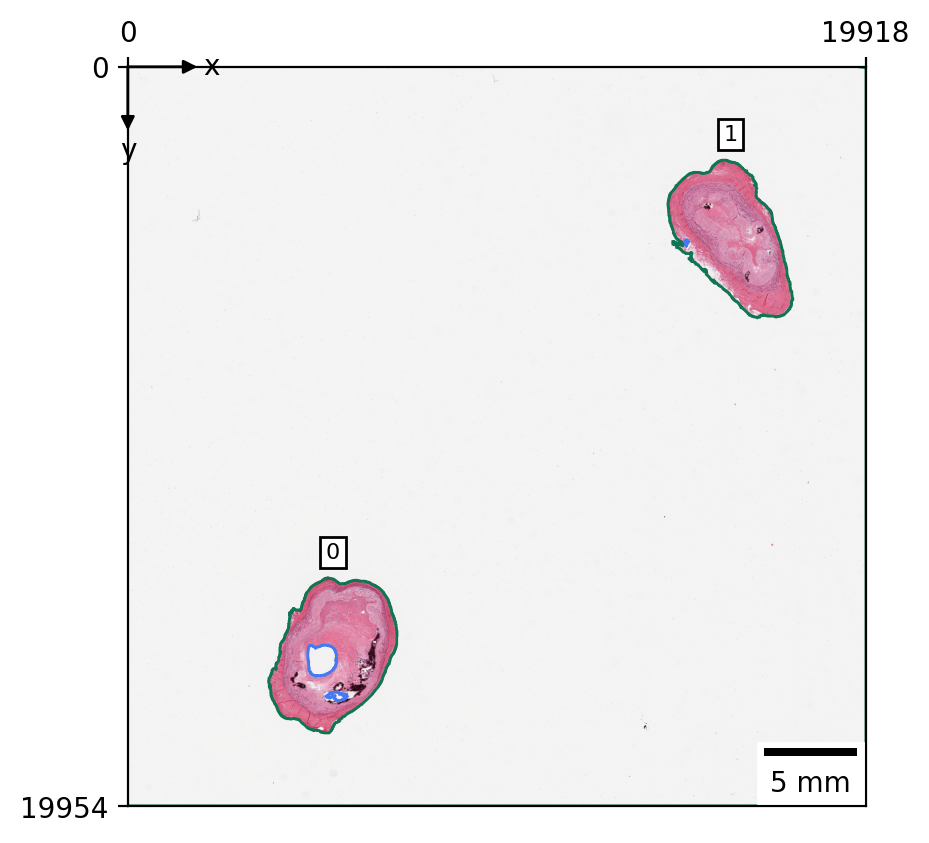

In [15]:
zs.pl.tissue(wsi, tissue_key="dl-tissues")

## Tissue QC/Scoring

If the scanning quality is not good, you can apply scorers on tissue pieces to check for their quality.

In [13]:
zs.pp.score_tissues(wsi, scores=["brightness", "redness"])

## Tissue properties

You can quickly get the geometry properties of each tissue instances.

In [15]:
zs.tl.tissue_props(wsi)

In [16]:
wsi["tissues"]

tissue_id                                           geometry  brightness  \
0          0  POLYGON ((5345.743 13804.501, 5337.74 13812.50...  188.943809   
1          1  POLYGON ((16029.226 2520.822, 16021.223 2528.8...  194.979504   

      redness       area  area_filled  convex_area  solidity  convexity  \
0  218.897005  9295453.0    9962045.0   10318845.0  0.900823   1.110096   
1  223.053437  8684173.0    8684173.0    9086193.5  0.955755   1.046293   

   axis_major_length  ...   moment-mu21   moment-mu12   moment-mu03  \
0        4348.672363  ...  1.881723e+14 -5.012970e+14  6.182167e+13   
1        4684.261719  ...  6.244954e+14  1.792367e+15  1.164329e+15   

   moment-nu20  moment-nu11  moment-nu02  moment-nu30  moment-nu21  \
0     0.068301    -0.026006     0.104072     0.000592     0.000601   
1     0.074724     0.048856     0.123623    -0.002956     0.002810   

   moment-nu12  moment-nu03  
0    -0.001600     0.000197  
1     0.008065     0.005239  

[2 rows x 53 columns]

## Tiling

The slide images are usually too large to fit into memory, a widly adopted strategy is to create smaller tiles or patches.

```{note}
If you are working with many slides from different sources. Harmonization is very important to account for batch effects. In tiling steps, if your slides have different magnification, you should specify a mpp value that the tiling should works on.
```

Here is a list of mpp value map with magnification:
<table>
    <thead>
        <tr>
            <th>Magnification</th>
            <th>MPP (Microns per Pixel)</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>40×</td>
            <td>0.25</td>
        </tr>
        <tr>
            <td>20×</td>
            <td>0.5</td>
        </tr>
        <tr>
            <td>10×</td>
            <td>1</td>
        </tr>
    </tbody>
</table>

In LazySlide, user can request tiles at any magnification level and arbitary size.

By default, the tiles are created without overlapping. The tiling parameters is stored as `tile_spec`.

In [18]:
zs.pp.tile_tissues(wsi, 256, mpp=0.5)
wsi.tile_spec("tiles")

Tile at 0.5 mpp, 256×256 (h×w)
Stride: 256×256 (0×0 overlap)
Operation size: 259×259, level=0
Base size: 259×259, level=0
Target tissue: 'tissues'

You can also specify the stride size to create overlapping.

In [19]:
zs.pp.tile_tissues(wsi, 256, stride_px=200, mpp=0.5, key_added="tile_stride_200")
wsi.tile_spec("tile_stride_200")

Tile at 0.5 mpp, 256×256 (h×w)
Stride: 200×200 (56×56 overlap)
Operation size: 259×259, level=0
Base size: 259×259, level=0
Target tissue: 'tissues'

The tiles are stored in a GeoDataFrame `tiles` (default name) and mapped to `tissue_id`.

In [42]:
wsi["tiles"]

id      x      y  tissue_id  \
0      0   3793  16394          0   
1      1   3793  16653          0   
2      2   4052  15617          0   
3      3   4052  15876          0   
4      4   4052  16135          0   
..   ...    ...    ...        ...   
249  249  17413   5887          1   
250  250  17413   6146          1   
251  251  17413   6405          1   
252  252  17672   5887          1   
253  253  17672   6146          1   

                                              geometry  
0    POLYGON ((4052 16394, 4052 16653, 3793 16653, ...  
1    POLYGON ((4052 16653, 4052 16912, 3793 16912, ...  
2    POLYGON ((4311 15617, 4311 15876, 4052 15876, ...  
3    POLYGON ((4311 15876, 4311 16135, 4052 16135, ...  
4    POLYGON ((4311 16135, 4311 16394, 4052 16394, ...  
..                                                 ...  
249  POLYGON ((17672 5887, 17672 6146, 17413 6146, ...  
250  POLYGON ((17672 6146, 17672 6405, 17413 6405, ...  
251  POLYGON ((17672 6405, 17672 6664, 17413 6664, ...  
252  POLYGON ((17931 5887, 17931 6146, 17672 6146, ...  
253  POLYGON ((17931 6146, 17931 6405, 17672 6405, ...  

[254 rows x 5 columns]

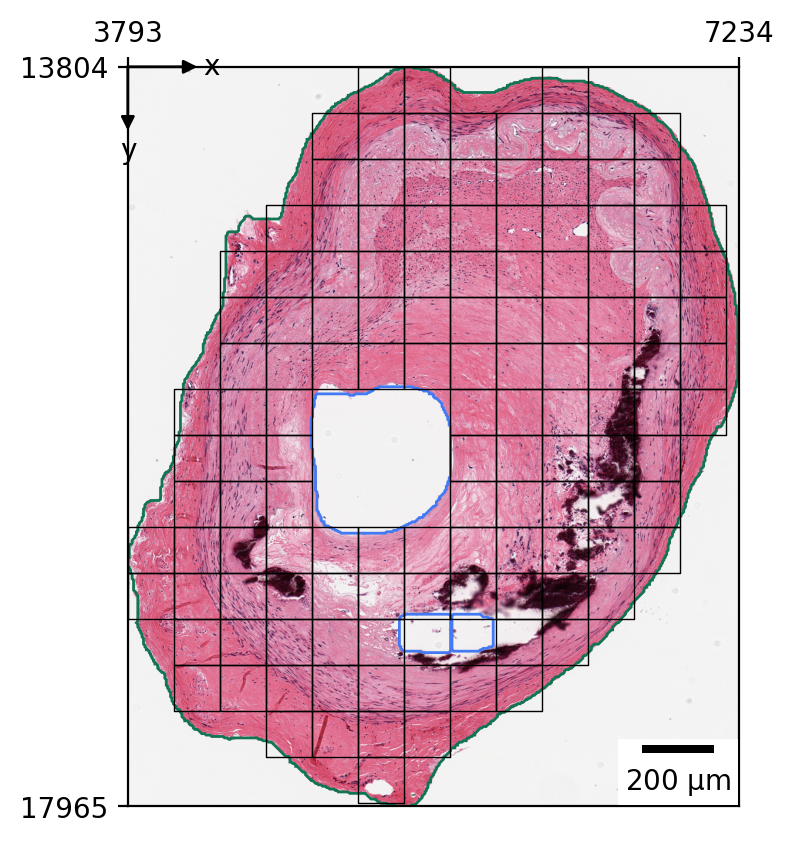

In [43]:
zs.pl.tiles(wsi, tissue_id=0, linewidth=0.5)

In [44]:
zs.pp.score_tiles(wsi, scorers=["contrast", "focus"], num_workers=4)

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.

In [45]:
wsi["tiles"]

id      x      y  tissue_id  \
0      0   3793  16394          0   
1      1   3793  16653          0   
2      2   4052  15617          0   
3      3   4052  15876          0   
4      4   4052  16135          0   
..   ...    ...    ...        ...   
249  249  17413   5887          1   
250  250  17413   6146          1   
251  251  17413   6405          1   
252  252  17672   5887          1   
253  253  17672   6146          1   

                                              geometry  contrast  focus  
0    POLYGON ((4052 16394, 4052 16653, 3793 16653, ...  0.623529    0.0  
1    POLYGON ((4052 16653, 4052 16912, 3793 16912, ...  0.623529    0.0  
2    POLYGON ((4311 15617, 4311 15876, 4052 15876, ...  0.792157    0.0  
3    POLYGON ((4311 15876, 4311 16135, 4052 16135, ...  0.768627    0.0  
4    POLYGON ((4311 16135, 4311 16394, 4052 16394, ...  0.619608    0.0  
..                                                 ...       ...    ...  
249  POLYGON ((17672 5887, 17672 6146, 17413 6146, ...  0.666667    0.0  
250  POLYGON ((17672 6146, 17672 6405, 17413 6405, ...  0.443137    0.0  
251  POLYGON ((17672 6405, 17672 6664, 17413 6664, ...  0.545098    0.0  
252  POLYGON ((17931 5887, 17931 6146, 17672 6146, ...  0.607843    0.0  
253  POLYGON ((17931 6146, 17931 6405, 17672 6405, ...  0.560784    0.0  

[254 rows x 7 columns]

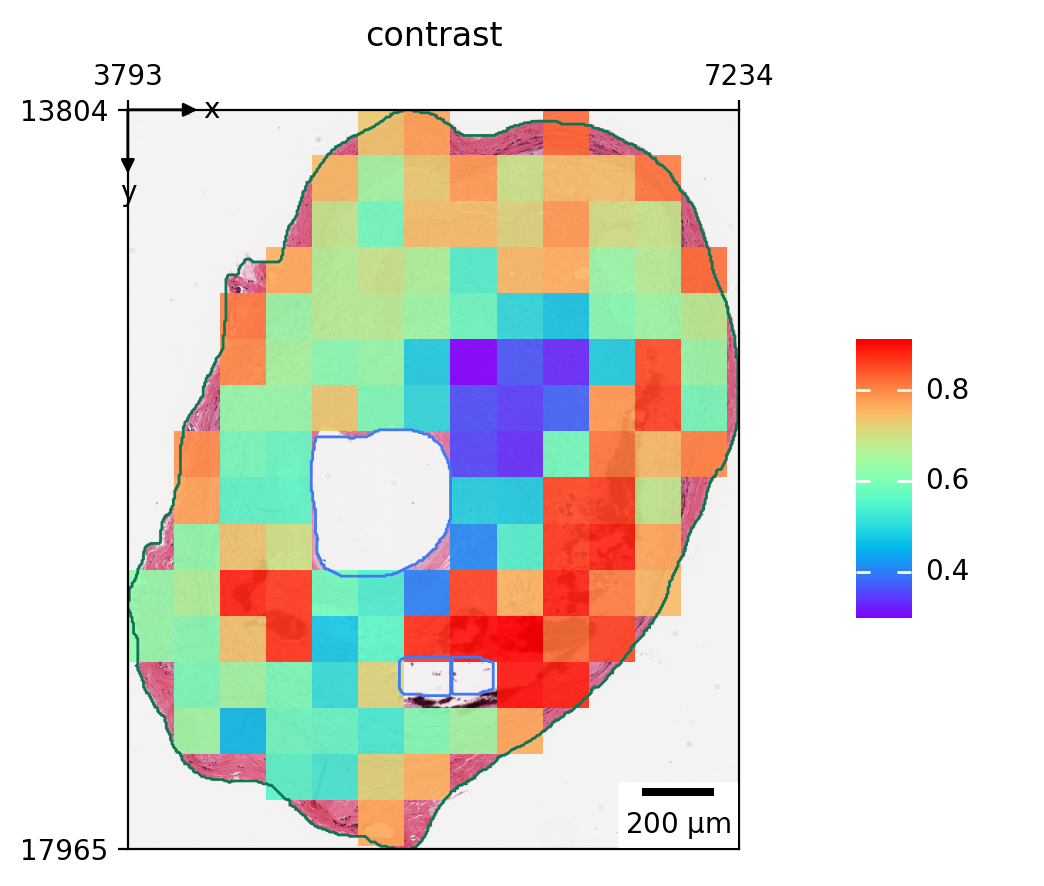

In [50]:
zs.pl.tiles(wsi, tissue_id=0, color="contrast", cmap="rainbow")

## Feature extraction

Feature extraction is to transform the image into a the numeric representation, which comprises of different morphological features. 

Typically, this is done by feeding the tiles into a vision model.

In [51]:
zs.tl.feature_extraction(wsi, "resnet50", device="mps")

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

You can easily use foundational models in LazySlide by specifying the name:

Currently supported: 'uni', 'uni2', 'conch', 'conch_vision', 'gigapath'

:::{note}
For foundation models, please request access at the corresponding huggingface repository.

In [ ]:
zs.tl.feature_extraction(wsi, "uni", device="mps")

WSI: GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
├── Shapes
│     ├── 'tile_stride_200': GeoDataFrame shape: (414, 5) (2D shapes)
│     ├── 'tile_stride_812': GeoDataFrame shape: (22, 5) (2D shapes)
│     ├── 'tiles': GeoDataFrame shape: (254, 7) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (2, 53) (2D shapes)
└── Tables
      └── 'resnet50_tiles': AnnData (254, 2048)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tile_stride_200 (Shapes), tile_stride_812 (Shapes), tiles (Shapes), tissues (Shapes)
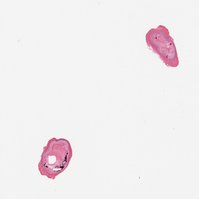

In [53]:
wsi

Features are saved as `AnnData` store with a convention of "{model name}_{tiles key}".

### Feature aggregation

To perform analysis across dataset, a usual way is to pool features into a 1D vector that can represent the entire slide.

Features can be aggregated at different levels, such as slide-level and tissue-level. 

In [54]:
zs.tl.feature_aggregation(wsi, "resnet50", by="slide")
zs.tl.feature_aggregation(wsi, "resnet50", by="tissue_id")

In [55]:
wsi["resnet50_tiles"]

AnnData object with n_obs × n_vars = 254 × 2048
    obs: 'tile_id', 'library_id', 'tissue_id'
    uns: 'spatialdata_attrs', 'agg_ops'
    varm: 'agg_slide', 'agg_tissue_id'

In [56]:
wsi.fetch.features_anndata("resnet50")

AnnData object with n_obs × n_vars = 254 × 2048
    obs: 'id', 'x', 'y', 'tissue_id', 'contrast', 'focus'
    uns: 'tile_spec', 'slide_properties'
    obsm: 'spatial'
    varm: 'agg_slide', 'agg_tissue_id'

## Save on the disk

The WSIData is saved side by side with your WSI file by default. When you open the WSI next time, it will automatically pick up the WSIData.

In [42]:
wsi.write()

INFO     The Zarr backing store has been changed from None the new file path: GTEX-11ZUS-2026.zarr                 


Notice that after saving, your `SpatialData` is now associated with a disk storage.

WSI: GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
├── Shapes
│     ├── 'tile_stride_200': GeoDataFrame shape: (414, 5) (2D shapes)
│     ├── 'tile_stride_812': GeoDataFrame shape: (22, 5) (2D shapes)
│     ├── 'tiles': GeoDataFrame shape: (254, 7) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (2, 53) (2D shapes)
└── Tables
      └── 'resnet50_tiles': AnnData (254, 2048)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tile_stride_200 (Shapes), tile_stride_812 (Shapes), tiles (Shapes), tissues (Shapes)
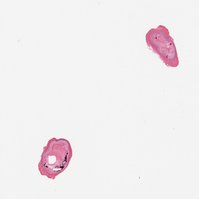

In [57]:
wsi